In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 62.5 MB/s 
     |████████████████████████████████| 163 kB 58.2 MB/s 
     |████████████████████████████████| 115 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 60.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
import datasets

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

In [4]:
cnn_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


In [5]:
type(cnn_data)

datasets.arrow_dataset.Dataset

In [6]:
#df = train_data.to_pandas()
#train set has 287113 records
df = pd.DataFrame(data=cnn_data)[:4000]

In [7]:
df.head()

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [8]:
df.columns

Index(['article', 'highlights', 'id'], dtype='object')

In [9]:
df.isna().sum()

article       0
highlights    0
id            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


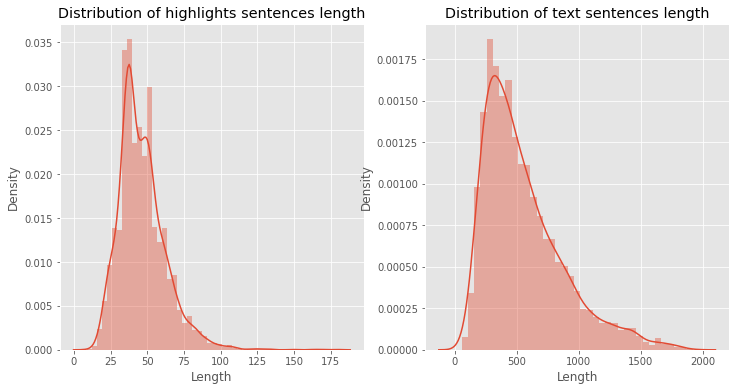

In [10]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(df['highlights'].str.split().apply(len))
plt.title('Distribution of highlights sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(df['article'].str.split().apply(len))
plt.title('Distribution of text sentences length')
plt.xlabel('Length')
plt.show()

##Text Cleaning

In [11]:
# Converting words to lowercase
df['highlights'] = df['highlights'].apply(lambda x: x.lower())
df['article'] = df['article'].apply(lambda x: x.lower())

In [12]:
df.head()

,article,highlights,id
0,(cnn)the palestinian authority officially beca...,membership gives the icc jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(cnn)never mind cats having nine lives. a stra...,"theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(cnn)if you've been following the news lately,...",mohammad javad zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(cnn)five americans who were monitored for thr...,17 americans were exposed to the ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(cnn)a duke student has admitted to hanging a ...,student is no longer on duke university campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [13]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [14]:
df['highlights'] = df['highlights'].apply(lambda x: remove_URL(x))
df['article'] = df['article'].apply(lambda x: remove_URL(x))

In [15]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [16]:
df['highlights'] = df['highlights'].apply(lambda x: remove_html(x))
df['article'] = df['article'].apply(lambda x: remove_html(x))

In [17]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

In [18]:
df['highlights'] = df['highlights'].apply(lambda x: remove_non_ascii(x))
df['article'] = df['article'].apply(lambda x: remove_non_ascii(x))

In [19]:
def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
df['highlights'] = df['highlights'].apply(lambda x: remove_special_characters(x))
df['article'] = df['article'].apply(lambda x: remove_special_characters(x))

In [21]:
def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)

In [22]:
df['highlights'] = df['highlights'].apply(lambda x: remove_punct(x))
df['article'] = df['article'].apply(lambda x: remove_punct(x))

In [23]:
df.head()

,article,highlights,id
0,cnnthe palestinian authority officially became...,membership gives the icc jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,cnnnever mind cats having nine lives a stray p...,theia a bully breed mix was apparently hit by ...,230c522854991d053fe98a718b1defa077a8efef
2,cnnif youve been following the news lately the...,mohammad javad zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,cnnfive americans who were monitored for three...,17 americans were exposed to the ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,cnna duke student has admitted to hanging a no...,student is no longer on duke university campus...,c27cf1b136cc270023de959e7ab24638021bc43f


## Text Preprocessing

In [24]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['article']),np.array(df['highlights']),test_size=0.1,random_state=0,shuffle=True)

In [25]:
#tokenize the text to get the vocab count 

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [26]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 61.31901679035738
Total Coverage of rare words: 2.604614632925091


In [27]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=2000, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=2000, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 22048


In [28]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [29]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.70954715892704
Total Coverage of rare words: 15.698445884279547


In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=70, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=70, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 3345
